In [ ]:
import re
import zarr
import glob
import torch
import pickle

import numpy as np
import matplotlib.pyplot as plt

from rich import print
from scipy import stats
from sortedcontainers import SortedKeyList
from alive_progress import alive_it
from omegaconf import OmegaConf
from pathlib import Path
from scipy.ndimage import zoom
from dataclasses import dataclass, fields
from matplotlib.colors import LinearSegmentedColormap

from walrus_workshop.model import load_sae
from walrus_workshop.walrus import get_trajectory
from walrus_workshop.metrics import compute_enstrophy#, compute_enstrophy_flux

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda


In [2]:
def search_filename(file_name, key) -> int:
    traj_match = re.search(rf"{key}_([+-]?\d+(?:e[+-]?\d+)?)", file_name, re.IGNORECASE)
    if traj_match:
        traj_number = int(traj_match.group(1))
        return traj_number
    else:
        raise ValueError(f"No number zfound in file name for {key}.")

In [3]:
# Load the config
cfg = OmegaConf.load("configs/train.yaml")

# Load the trajectory
trajectory_id = 50
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}*")))
# List of steps with activations (starting step)
steps = np.array([search_filename(file_name, "step") for file_name in act_files])

# Load the trained SAE
checkpoint_path = (
    Path("checkpoints")
    / "sae_checkpoint_blocks.20.space_mixing.activation_source_test_k_active=32_k_aux=2048_latent=22528_beta=0.1.pt"
)
sae_model, sae_config = load_sae(checkpoint_path)
sae_model = sae_model.to(device).eval()

In [4]:
step_index = 1
step = steps[step_index]
print(f"Step {step}")

Step 5


In [ ]:
# Load the errors
from script_walrus_errors import WalrusError
errors = pickle.load(open(Path("errors") / f"errors_{trajectory_id}.pkl", "rb"))

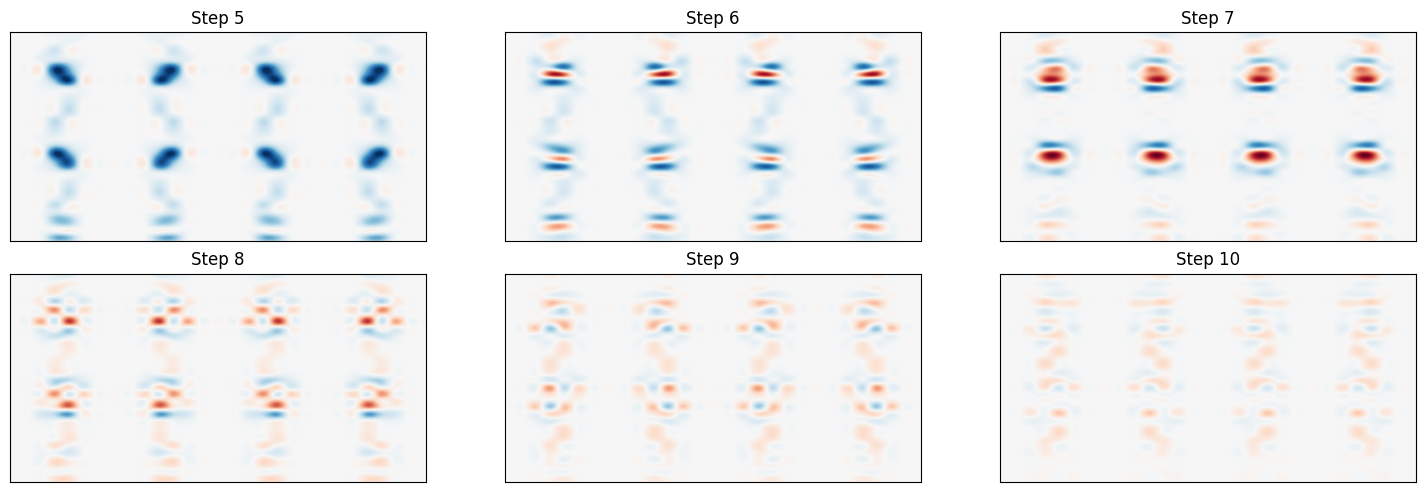

In [5]:
# Plot dEdT
simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input+1, :, :, 0, :]

scale_x = int(simulation_chunk.shape[2] / 32)  # width
scale_y = int(simulation_chunk.shape[1] / 32)  # height

enstrophy = np.zeros((simulation_chunk.shape[0], 32, 32))
for i in range(simulation_chunk.shape[0]):
    for ix in range(32):
        for iy in range(32):
            token = simulation_chunk[i, iy*scale_y:(iy+1)*scale_y, ix*scale_x:scale_x*(ix+1), :]
            enstrophy[i, iy, ix] = compute_enstrophy(token[:, :, 2], token[:, :, 3])[0]
dEdt = -1*np.diff(enstrophy, axis=0)
vmax = np.max(np.abs(dEdt))

fig, axs = plt.subplots(2, 3, figsize=(15, 5))
for i in range(dEdt.shape[0]):
    ax = axs[i // 3, i % 3]
    ax.imshow(zoom(dEdt[i], (scale_y, scale_x), grid_mode=True, mode='grid-constant'), cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    ax.set_title(f"Step {step + i}")
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()


In [6]:
# simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input, :, :, 0, :] # NOTE: Using the entire input chunk
# nx = simulation_chunk.shape[1]
# ny = simulation_chunk.shape[2]
# dx = nx // 32
# dy = ny // 32

# enstrophy = np.zeros((simulation_chunk.shape[0], 32, 32))
# for i in range(simulation_chunk.shape[0]):
#     for ix in range(32):
#         for iy in range(32):
#             token = simulation_chunk[i, ix*dx:(ix+1)*dx, iy*dy:dy*(iy+1), :]
#             _,__,___ = compute_enstrophy_flux(token[:, :, 2], token[:, :, 3])[0]
# dEdt = -1*np.diff(enstrophy, axis=0)
# vmax = np.max(np.abs(dEdt))
# print(dEdt.shape)

# # for i in range(simulation_chunk.shape[0]):
# #     k_centers, Pi_omega, T_omega = compute_enstrophy_flux(simulation_chunk[i, :, :, 2], simulation_chunk[i, :, :, 3])
# #     plt.plot(k_centers, Pi_omega, c=f'C{i}', label=f"Step {step + i}")
# # plt.xlabel("Wavenumber")
# # plt.ylabel("Enstrophy Flux")
# # plt.legend()
# # plt.show()

# # enstrophy_flux = np.zeros((simulation_chunk.shape[0], 32, 32))
# # for i in range(simulation_chunk.shape[0]):
# #     for ix in range(32):
# #         for iy in range(32):
# #             token = simulation_chunk[i, ix*dx:(ix+1)*dx, iy*dy:dy*(iy+1), :]
# #             enstrophy_flux[i, ix, iy] = compute_enstrophy_flux(token[:, :, 2], token[:, :, 3])[0]
# # print(enstrophy_flux.shape)

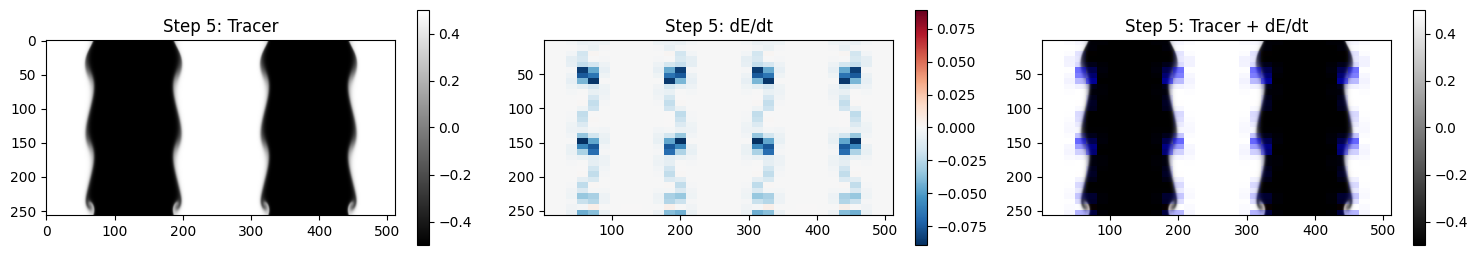

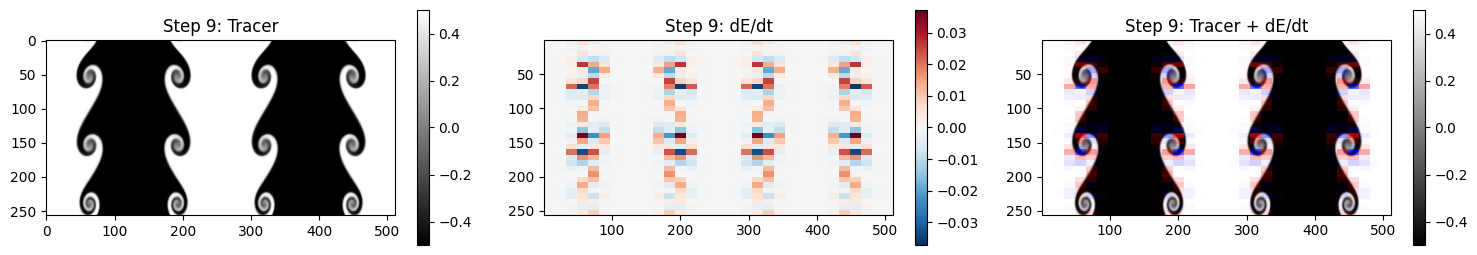

In [6]:
@dataclass
class EnstrophyData:
    step: int
    simulation: np.ndarray # T x 256 x 512 x 5 array
    enstrophy: np.ndarray # 32 x 32 array
    dEdt: np.ndarray # 32 x 32
    zoom_dEdt: np.ndarray # 256 x 512

def plot_enstrophy_evolution(trajectory, start_step, cfg, substep=0):

    assert substep < cfg.walrus.n_steps_input - 1

    step = start_step
    simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input+1, :, :, 0, :] # NOTE: Using the entire input chunk

    scale_x = int(simulation_chunk.shape[2] / 32)  # width
    scale_y = int(simulation_chunk.shape[1] / 32)  # height

    enstrophy = np.zeros((simulation_chunk.shape[0], 32, 32))
    for i in range(simulation_chunk.shape[0]):
        for ix in range(32):
            for iy in range(32):
                token = simulation_chunk[i, iy*scale_y:(iy+1)*scale_y, ix*scale_x:scale_x*(ix+1), :]
                enstrophy[i, iy, ix] = compute_enstrophy(token[:, :, 2], token[:, :, 3])[0]
    dEdt = -1*np.diff(enstrophy, axis=0)
    zoom_dEdt = zoom(dEdt, (1, scale_y, scale_x), grid_mode=True, mode='grid-constant')
    vmax = np.max(np.abs(dEdt[substep]))

    extent = (0.5, dEdt.shape[1] * scale_x - 0.5, dEdt.shape[2] * scale_y - 0.5, 0.5)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    cm = axs[0].imshow(simulation_chunk[substep, :, :, 0], cmap="gray")
    fig.colorbar(cm, ax=axs[0], shrink=0.5)
    cm = axs[1].imshow(dEdt[substep], cmap="RdBu_r", vmin=-vmax, vmax=vmax, extent=extent)
    # cm = axs[1].imshow(zoom_dEdt[substep], cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    fig.colorbar(cm, ax=axs[1], shrink=0.5)
    cm = axs[2].imshow(simulation_chunk[substep, :, :, 0], cmap="gray")
    axs[2].imshow(dEdt[substep], cmap=LinearSegmentedColormap.from_list('mask', [(1, 0, 0, 0), (1, 0, 0, 0.6)]), vmin=0, vmax=vmax, extent=extent)
    axs[2].imshow(dEdt[substep], cmap=LinearSegmentedColormap.from_list('mask', [(0, 0, 1, 0), (0, 0, 1, 0.6)]).reversed(), vmin=-vmax, vmax=0, extent=extent)
    fig.colorbar(cm, shrink=0.5)

    axs[0].set_title(f"Step {step + substep}: Tracer")
    axs[1].set_title(f"Step {step + substep}: dE/dt")
    axs[2].set_title(f"Step {step + substep}: Tracer + dE/dt")
    fig.tight_layout()
    plt.show()

    return EnstrophyData(step=step, simulation=simulation_chunk[:-1], enstrophy=enstrophy, dEdt=dEdt, zoom_dEdt=zoom_dEdt)

enstrophy_data = plot_enstrophy_evolution(trajectory, start_step=step, cfg=cfg);
plot_enstrophy_evolution(trajectory,  start_step=step, cfg=cfg,substep=4);



In [7]:
# Get the enstrophy data and SAE features
print(f"Opening activation file {Path(act_files[step_index]).stem}")
assert search_filename(Path(act_files[step_index]).stem, "step") == step # make sure we are processing the same step
act = zarr.open(act_files[step_index], mode="r")
act = torch.from_numpy(np.array(act)).to(device)
with torch.no_grad():
    _, code, _ = sae_model(act)
code = code.cpu().numpy()

Opening activation file step_0005_traj_50_Reynolds_1e+05_Schmidt_5e-01_layerblocks.20.space_mixing.activation


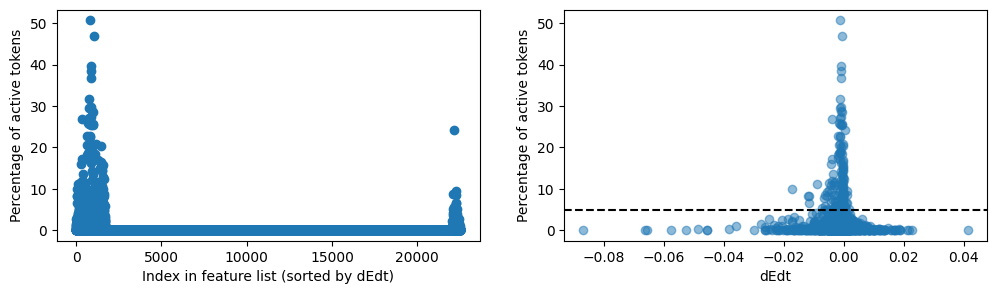

In [8]:
# sort the features by activation weighted dEdt for this snapshot
@dataclass
class Feature:
    index: int
    dEdt: float
    num_active: int

    def __lt__(self, other): # For min-heap: dEdt = lower priority
        return self.dEdt < other.dEdt

# Loop over all the features and order by activation weighted dEdt
feature_list = SortedKeyList()
for i in range(code.shape[1]):
    feature_values = code[:, i] # feature values for each of the "tokens" (e.g. pixels in the simulation); 6 x 32 x 32
    if np.sum(feature_values) > 0:
        feature_weighted_dEdt = np.dot(feature_values,enstrophy_data.dEdt.ravel()) / np.sum(feature_values)
        feature_list.add(Feature(index=i, dEdt=float(feature_weighted_dEdt), num_active=int(np.sum(feature_values > 0))))
    else:
        feature_list.add(Feature(index=i, dEdt=0, num_active=0))

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot([100 * feature.num_active / (32 * 32 * 6) for feature in feature_list], 'o')
ax[0].set_xlabel("Index in feature list (sorted by dEdt)")
ax[0].set_ylabel("Percentage of active tokens")
ax[1].scatter([feature.dEdt for feature in feature_list], [100 * feature.num_active / (32 * 32 * 6) for feature in feature_list], alpha=0.5)
ax[1].axhline(5, color="k", linestyle="--")
ax[1].set_xlabel("dEdt")
ax[1].set_ylabel("Percentage of active tokens")
plt.show()


In [9]:
# def plot_feature(feature: Feature, enstrophy_data: EnstrophyData, substep=0):
#     activations = code[:, feature.index].reshape(-1, 32, 32).sum(axis=0)
#     fig, ax = plt.subplots(1, 3, figsize=(15, 8))
#     ax[0].imshow(enstrophy_data.simulation[0, :, :, 0], cmap="gray")
#     vmax = np.max(np.abs(enstrophy_data.dEdt[substep]))
#     ax[1].imshow(zoom(enstrophy_data.dEdt[substep], (8, 16)), cmap="RdBu_r", vmin=-vmax, vmax=vmax)
#     ax[2].imshow(enstrophy_data.simulation[substep, :, :, 0], cmap="gray")
#     ax[2].imshow(zoom(activations, (8, 16)), cmap=LinearSegmentedColormap.from_list('mask', [(0.5, 0, 0.5, 0), (0.5, 0, 0.5, 0.6)]), vmin=0, vmax=activations.max())
#     for ax in ax:
#         ax.set_xticks([])
#         ax.set_yticks([])
#     plt.show()

def plot_feature(feature: Feature, enstrophy_data: EnstrophyData, show_simulation=True):
    activations = code[:, feature.index].reshape(-1, 32, 32)
    # dx = enstrophy_data.simulation.shape[1] / activations.shape[1]
    # dy = enstrophy_data.simulation.shape[2] / activations.shape[2]
    # extent = (0.5, activations.shape[1] * dy - 0.5, activations.shape[2] * dx - 0.5, 0.5)
    H, W = enstrophy_data.simulation.shape[1], enstrophy_data.simulation.shape[2]
    extent = (-0.5, W - 0.5, H - 0.5, -0.5)    
    fig, axs = plt.subplots(2, 3, figsize=(15, 5))
    for i in range(enstrophy_data.simulation.shape[0]):
        ax = axs[i // 3, i % 3]
        if show_simulation:
            ax.imshow(enstrophy_data.simulation[i, :, :, 0], cmap="gray")
        else:
            vmax = np.max(np.abs(enstrophy_data.zoom_dEdt[i]))
            ax.imshow(enstrophy_data.dEdt[i], cmap="RdBu_r", vmin=-vmax, vmax=vmax, extent=extent)
            # ax.imshow(enstrophy_data.zoom_dEdt[i], cmap="RdBu_r", vmin=-vmax, vmax=vmax)
        ax.imshow(activations[i], cmap=LinearSegmentedColormap.from_list('mask', [(0.5, 0, 0.5, 0), (0.5, 0, 0.5, 0.6)]), vmin=0, vmax=activations.max(), extent=extent)
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.show()

# def plot_feature(feature: Feature, enstrophy_data: EnstrophyData, show_simulation=True):
#     activations = code[:, feature.index].reshape(6, 32, 32)
#     fig, axes = plt.subplots(2, 3, figsize=(12, 5))
#     for i in range(activations.shape[0]):
#         ax = axes[i // 3, i % 3]
#         ax.imshow(activations[i])
#         ax.contour(np.arange(512) / 16 - 0.5, np.arange(256) / 8 - 0.5, enstrophy_data.simulation[i, :, :, 0], levels=1, colors="k")
#         ax.set_xticks([])
#         ax.set_yticks([])
#     fig.tight_layout()
#     plt.show()



In [10]:
def plot_feature_list(feature_list, enstrophy_data, show_simulation=True):
    feature_map = np.zeros((6, 32, 32))
    for feature in feature_list:
        activations = code[:, feature.index].reshape(6, 32, 32)
        feature_map += activations
    H, W = enstrophy_data.simulation.shape[1], enstrophy_data.simulation.shape[2]
    extent = (-0.5, W - 0.5, H - 0.5, -0.5)
    fig, axs = plt.subplots(2, 3, figsize=(15, 5))
    for i in range(enstrophy_data.simulation.shape[0]):
        ax = axs[i // 3, i % 3]
        if show_simulation:
            ax.imshow(enstrophy_data.simulation[i, :, :, 0], cmap="gray")
        else:
            vmax = np.max(np.abs(enstrophy_data.zoom_dEdt[i]))
            # ax.imshow(enstrophy_data.dEdt[i], cmap="RdBu_r", vmin=-vmax, vmax=vmax, extent=extent)
            ax.imshow(enstrophy_data.zoom_dEdt[i], cmap="RdBu_r", vmin=-vmax, vmax=vmax)
        ax.imshow(feature_map[i], cmap=LinearSegmentedColormap.from_list('mask', [(0.5, 0, 0.5, 0), (0.5, 0, 0.5, 0.6)]), vmin=0, 
        vmax=feature_map[i].max(), extent=extent)
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.show()


## Bingo!

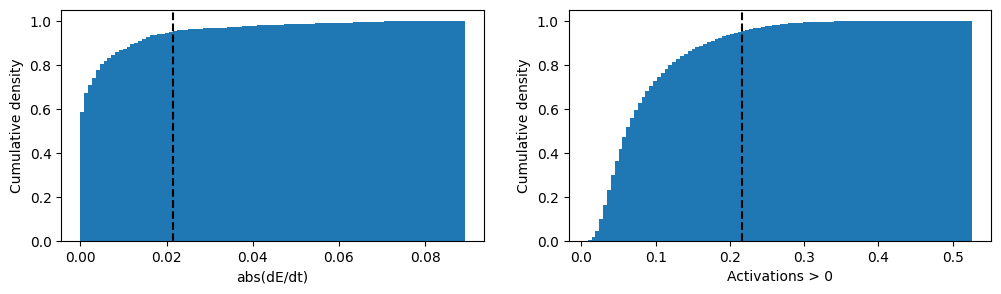

code 95%: 0.2165948450565338
dEdt 95%: 0.021533788088709056


In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12,3))
ax = axs[0]
ax.hist(np.abs(enstrophy_data.dEdt.ravel()), bins=100, cumulative=True, density=True)
ax.axvline(np.percentile(np.abs(enstrophy_data.dEdt.ravel()), 95), color="k", linestyle="--")
ax.set_xlabel("abs(dE/dt)")
ax.set_ylabel("Cumulative density")

ax = axs[1]
ax.hist(code[code > 0], bins=100, density=True, cumulative=True)
ax.axvline(np.percentile(code[code > 0], 95), color="k", linestyle="--")
ax.set_xlabel("Activations > 0")
ax.set_ylabel("Cumulative density")
plt.show()

print(f"code 95%: {np.percentile(code[code > 0], 95)}")
print(f"dEdt 95%: {np.percentile(np.abs(enstrophy_data.dEdt.ravel()), 95)}")

In [ ]:
@dataclass
class BingoFeature:
    index: int # index into code
    coverage: float
    std_coverage: float
    corr: float

dEdt_thresh = 0.01
activations_thresh = 0.0
enstrophy_mask = np.abs(enstrophy_data.dEdt) > dEdt_thresh # any
# enstrophy_mask = enstrophy_data.dEdt > dEdt_thresh # positive
# enstrophy_mask = enstrophy_data.dEdt < -dEdt_thresh # negative
print(enstrophy_mask.shape)
print(f"mean dEdt: {enstrophy_data.dEdt.mean()}")
print(f"mean dEdt (masked): {enstrophy_data.dEdt[enstrophy_mask].mean()}")

bingo_features = SortedKeyList(key=lambda x: np.abs(x.coverage))
for feature in alive_it(feature_list, force_tty=True, total=len(feature_list)):
    activations = code[:, feature.index].reshape(-1, 32, 32) # Reshape to T, X, Y (how do we know that is the right shape?)
    # coverage = np.zeros(enstrophy_data.dEdt.shape[0])
    if activations.sum() > 0:
        coverage = np.zeros(enstrophy_data.dEdt.shape[0])
        for i in range(enstrophy_data.dEdt.shape[0]): # loop over time
            # coverage[i] = np.sum(activations[i][enstrophy_mask[i]] > activations_thresh) / np.sum(activations[i] > activations_thresh) # fraction of feature
            coverage[i] = np.sum(activations[i][enstrophy_mask[i]] > activations_thresh) / np.sum(enstrophy_mask[i]) # fraction of enstrophy mask
        if np.any(np.isfinite(coverage)):
            corr = stats.spearmanr(activations.ravel(), enstrophy_data.dEdt.ravel())[0]
            bingo_features.add(BingoFeature(index=feature.index, coverage=np.nanmean(coverage), std_coverage=np.nanstd(coverage), corr=corr))
print(f"Number of bingo features: {len(bingo_features)} / {len(feature_list)}")

(6, 32, 32)

mean dEdt: -0.001429739135008277

mean dEdt (masked): -0.007272316417220282

|████████████████████████████████████████| 22528/22528 [100%] in 4.1s (5524.77/s


Number of bingo features: 2218 / 22528

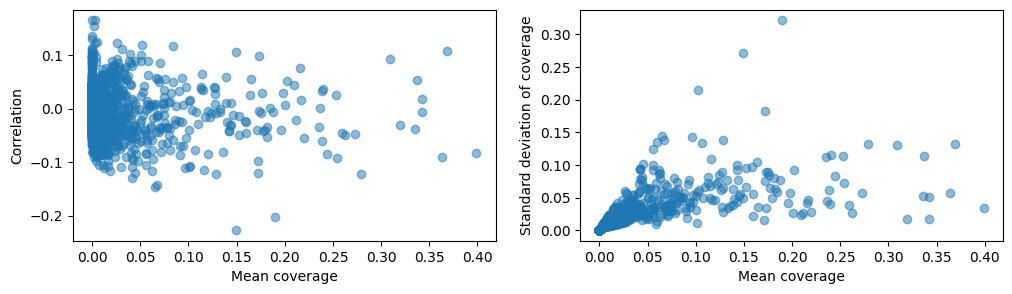

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].scatter([b.coverage for b in bingo_features], [b.corr for b in bingo_features], alpha=0.5)
axs[0].set_xlabel("Mean coverage")
axs[0].set_ylabel("Correlation")
axs[1].scatter([b.coverage for b in bingo_features], [b.std_coverage for b in bingo_features], alpha=0.5)
axs[1].set_xlabel("Mean coverage")
axs[1].set_ylabel("Standard deviation of coverage")
plt.show()
    

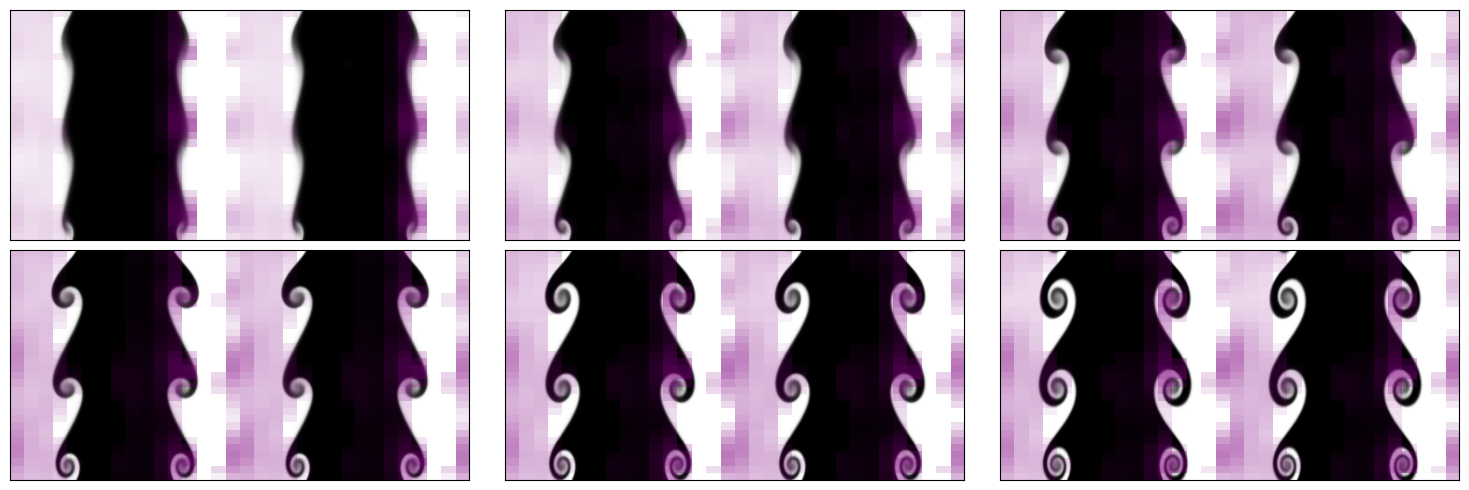

In [31]:
plot_feature_list(bingo_features[::-1][:2], enstrophy_data, show_simulation=True)

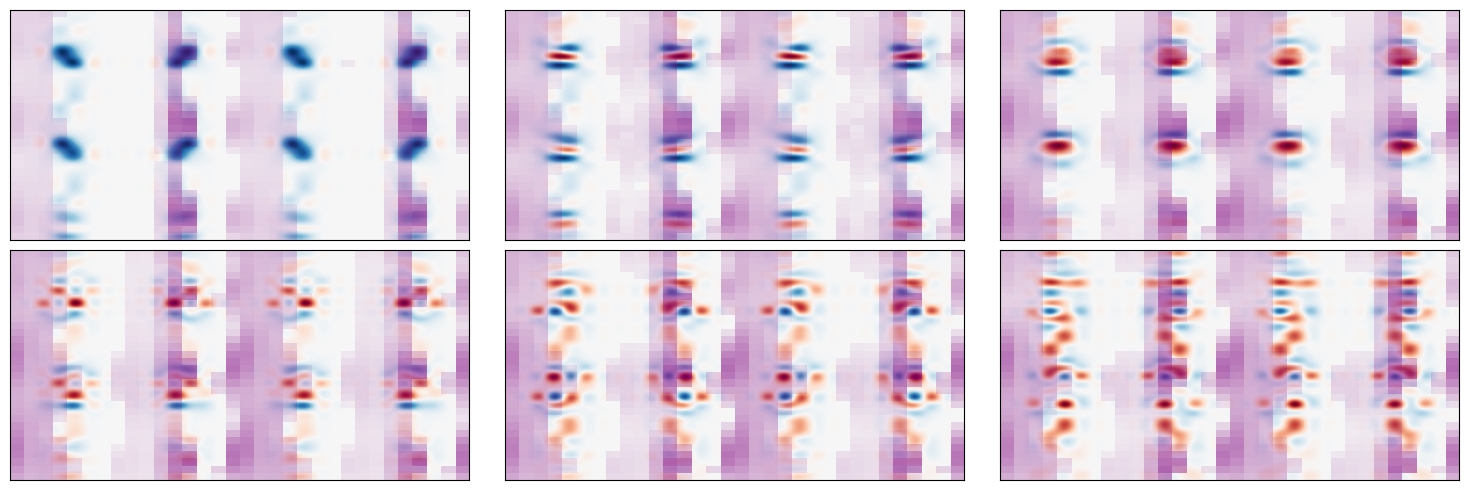

In [32]:
plot_feature_list(bingo_features[::-1][:2], enstrophy_data, show_simulation=False)

In [17]:
# # activations: [N, X], cascade_metric: [N,]
# num_features = code.shape[1]

# correlations = np.zeros(len(bingo_features))
# p_values = np.zeros(len(bingo_features))
# for i, feature in enumerate(bingo_features):
#     activations = code[:, feature.index].reshape(-1, 32, 32)
#     correlations[i], p_values[i] = stats.spearmanr(activations.ravel(), enstrophy_data.dEdt.ravel())

# # Apply multiple testing correction (Bonferroni)
# significant_features_indices = np.where(p_values < 0.05 / num_features)[0]
# # some info
# print(f"Number of significant features: {len(significant_features_indices)}")
# print(f"Correlation of the most significant features: {correlations[:5]}, {correlations[::-1][:5]}")
# significant_features = [feature_list[i] for i in significant_features_indices]

In [33]:
# Combine the features, sorted by 

# activations: [N, X], cascade_metric: [N,]
num_features = code.shape[1]

top_k = 100
cum_correlations = np.zeros(top_k)
cum_p_values = np.zeros(top_k)
for i in range(top_k):
    activations = np.zeros((6, 32, 32))
    for feature in bingo_features[::-1][:i+1]:
        correlation = stats.spearmanr(code[:, feature.index], enstrophy_data.dEdt.ravel())[0]
        sign = np.sign(correlation)
        activations += code[:, feature.index].reshape(-1, 32, 32) * sign
    cum_correlations[i], cum_p_values[i] = stats.spearmanr(activations.ravel(), enstrophy_data.dEdt.ravel())

# Apply multiple testing correction (Bonferroni)
significant_features_indices = np.where(cum_p_values < 0.05 / num_features)[0]
# some info
print(f"Number of significant features: {len(significant_features_indices)}")
print(f"Correlation of the most significant features: {cum_correlations[:5]}, {cum_correlations[::-1][:5]}")
significant_features = [feature_list[i] for i in significant_features_indices]

Number of significant features: 100

Correlation of the most significant features: [0.08389158 0.12499841 0.14383195 0.13473848 0.1571581 ], [0.25152375
0.24974604 0.24960294 0.2489323  0.25037194]

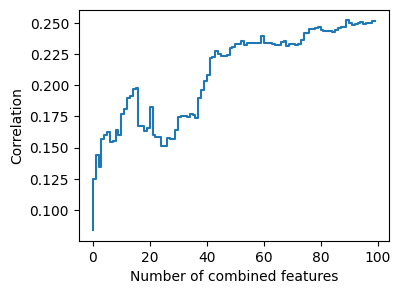

In [34]:
fig, ax = plt.subplots(figsize=(4,3))
plt.step(np.arange(top_k), cum_correlations)
plt.xlabel("Number of combined features")
plt.ylabel("Correlation")
plt.show()

## Error prediction

In [11]:
def bin_error(error, shape=(32, 32), f=np.mean, field=0):
    e = np.squeeze(error.pred[..., field]) - np.squeeze(error.ref[..., field])
    print(e.shape)
    scale_y = e.shape[0] // shape[0]
    scale_x = e.shape[1] // shape[1]
    
    # Truncate to evenly divisible size, then reshape into bins
    truncated = e[:shape[0] * scale_y, :shape[1] * scale_x]
    reshaped = truncated.reshape(shape[0], scale_y, shape[1], scale_x)
    
    return f(reshaped, axis=(1, 3))

(256, 512)


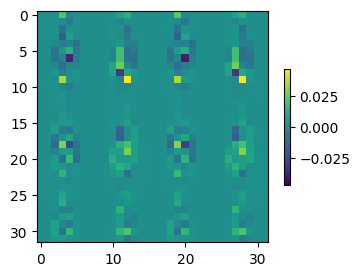

In [ ]:
from script_walrus_errors import WalrusError
errors = pickle.load(open(Path("errors") / "errors_50.pkl", "rb"))
error = errors[step_index]

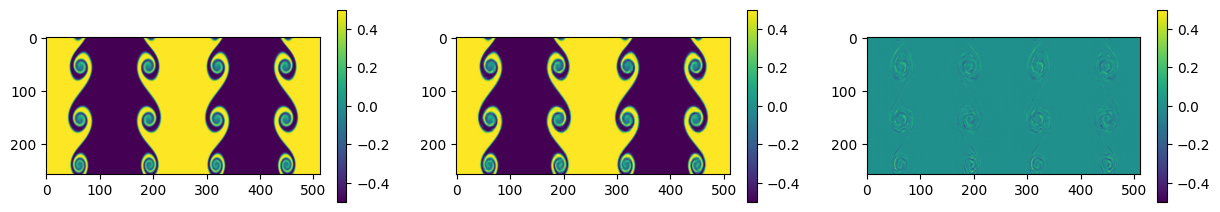

In [73]:
vmax = np.max(np.abs(np.squeeze(error.ref[..., 0])))
e = np.squeeze(error.pred) - np.squeeze(error.ref)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
cm = axs[0].imshow(np.squeeze(error.ref[..., 0]), vmin=-vmax, vmax=vmax)
fig.colorbar(cm, ax=axs[0], shrink=0.5)
axs[1].imshow(np.squeeze(error.pred[..., 0]), vmin=-vmax, vmax=vmax)
fig.colorbar(cm, ax=axs[1], shrink=0.5)
axs[2].imshow(np.squeeze(error.ref[..., 0]) - np.squeeze(error.pred[..., 0]), vmin=-vmax, vmax=vmax)
fig.colorbar(cm, ax=axs[2], shrink=0.5)
plt.show()

(256, 512)

|████████████████████████████████████████| 2218/2218 [100%] in 1.1s (1988.59/s) 


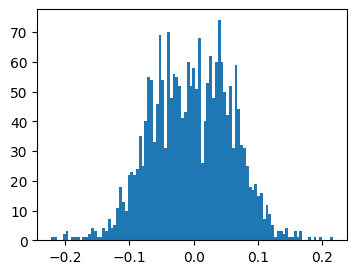

In [35]:
correlations = np.zeros(len(bingo_features))
p_values = np.zeros(len(bingo_features))
e = bin_error(error:=errors[step_index])
assert error.trajectory_id == trajectory_id
assert error.step == step

# Loop over our bingo features
for i, feature in alive_it(enumerate(bingo_features[::-1]), force_tty=True, total=len(bingo_features)):
    # Get the activations for this feature
    activations = code[:, feature.index].reshape(-1, 32, 32)
    # Get the correlation for this feature
    correlations[i], p_values[i] = stats.spearmanr(activations.reshape(-1, 32, 32).sum(axis=0).ravel(), e.ravel())

plt.figure(figsize=(4,3))
plt.hist(correlations, bins=100)
plt.show()

In [36]:
print(correlations[:5])

[0.09657321 0.0476673  0.02624467 0.14614728 0.0245414 ]

(256, 512)

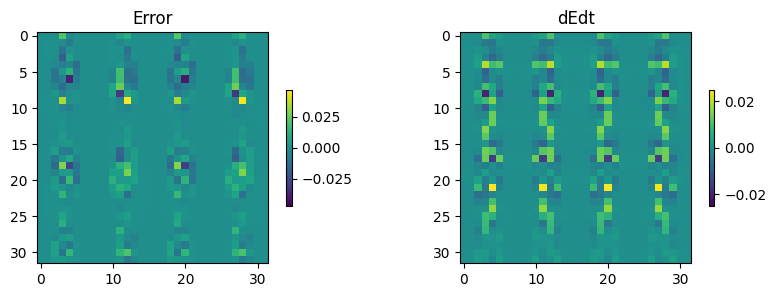

In [41]:
e = bin_error(error)
vmax = np.max(np.abs(e))
fig, axs = plt.subplots(1, 2, figsize=(10,3))
cm = axs[0].imshow(e, vmin=-vmax, vmax=vmax)
fig.colorbar(cm, ax=axs[0], shrink=0.5)
axs[0].set_title("Error")
vmax = np.max(np.abs(enstrophy_data.dEdt[-1]))
cm = axs[1].imshow(enstrophy_data.dEdt[-1], vmin=-vmax, vmax=vmax)
axs[1].set_title("dEdt")
# axs[1].imshow(e, cmap=LinearSegmentedColormap.from_list('mask', [(0.5, 0, 0.5, 0), (0.5, 0, 0.5, 0.6)]), vmin=-vmax, vmax=vmax)
fig.colorbar(cm, ax=axs[1], shrink=0.5)
plt.show()

In [20]:
# for cnt, feature in enumerate(bingo_features[::-1]):
#     if cnt == 2:
#         break
#     print(f"Feature {feature.index} has a mean coverage of {feature.coverage:.2f} and a std coverage of {feature.std_coverage:.2f} and correlation of {feature.corr:.2f}")
#     plot_feature(feature, enstrophy_data, show_simulation=True)

## Correlation analysis

### Basic correlations

In [ ]:


@dataclass
class CorrFeature:
    index: int
    correlation: float
    p_value: float

corr_features = SortedKeyList(key=lambda x: x.correlation)

for feature in alive_it(feature_list, force_tty=True, total=len(feature_list)):
    corr, p_val = stats.spearmanr(code[:, feature.index], enstrophy_data.dEdt.ravel())
    corr_features.add(CorrFeature(index=feature.index, correlation=corr, p_value=p_val))

print(f"Number of correlation features: {len(corr_features)}")
print(f"Correlation of the most significant features: {corr_features[:5]}, {corr_features[::-1][:5]}")

on 1739: /tmp/ipykernel_1302251/1575553270.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
           corr, p_val = stats.spearmanr(code[:, feature.index], enstrophy_data.dEdt.ravel())


|████████████████████████████████████████| 22528/22528 [100%] in 4.2s (5489.75/s


Number of correlation features: 22528

Correlation of the most significant features: [CorrFeature(index=9301, 
correlation=np.float64(-0.22750518542970424), p_value=np.float64(5.85407183359779e-73)), CorrFeature(index=9166, 
correlation=np.float64(-0.20193006226453858), p_value=np.float64(1.5055615416322015e-57)), CorrFeature(index=12227,
correlation=np.float64(-0.14752102793988875), p_value=np.float64(3.092592453851559e-31)), CorrFeature(index=6507, 
correlation=np.float64(-0.14267173921462212), p_value=np.float64(2.64145640682891e-29)), CorrFeature(index=19467, 
correlation=np.float64(-0.1301067498701744), p_value=np.float64(1.3161652154616674e-24))], [CorrFeature(index=5899,
correlation=np.float64(0.1650090515280933), p_value=np.float64(9.327334839757426e-39)), CorrFeature(index=7075, 
correlation=np.float64(0.10118020475246399), p_value=np.float64(1.8700947027078735e-15)), CorrFeature(index=481, 
correlation=np.float64(0.0982780513517043), p_value=np.float64(1.1585382627547245e-14)), CorrFeature(index=21764, 
correlation=np.float64(0.09612109476447227), p_value=np.float64(4.343282773696729e-14)), CorrFeature(index=22226, 
correlation=np.float64(0.09286582692312195), p_value=np.float64(3.021210327420698e-13))]

Feature 9301 has a correlation of -0.23 and a p-value of 5.85e-73


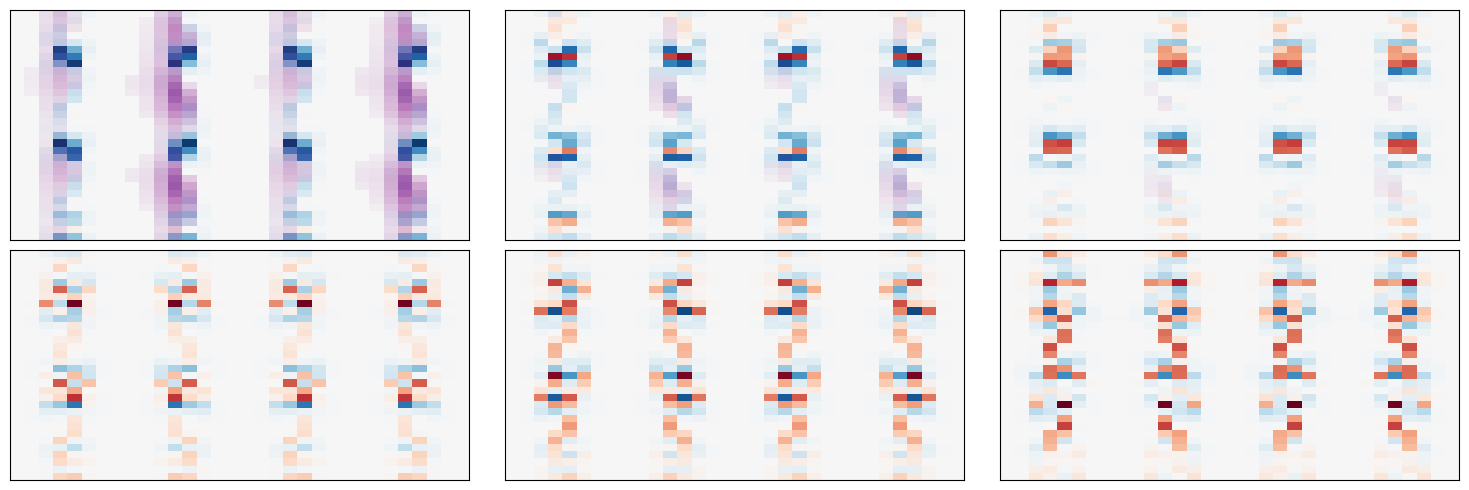

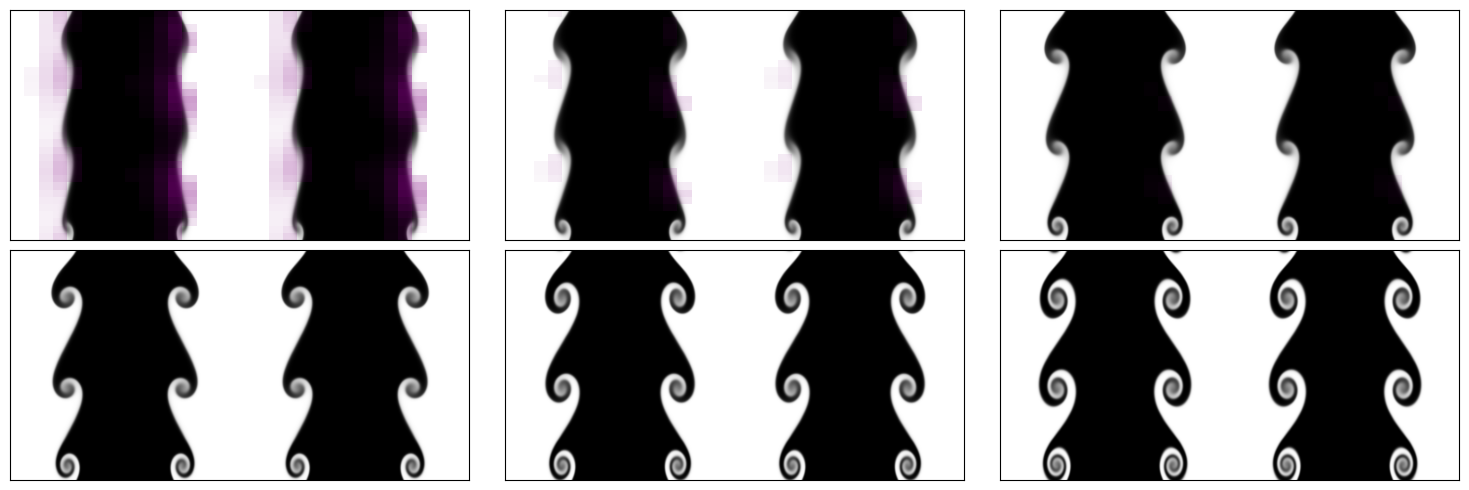

__________________________________
Feature 9166 has a correlation of -0.20 and a p-value of 1.51e-57


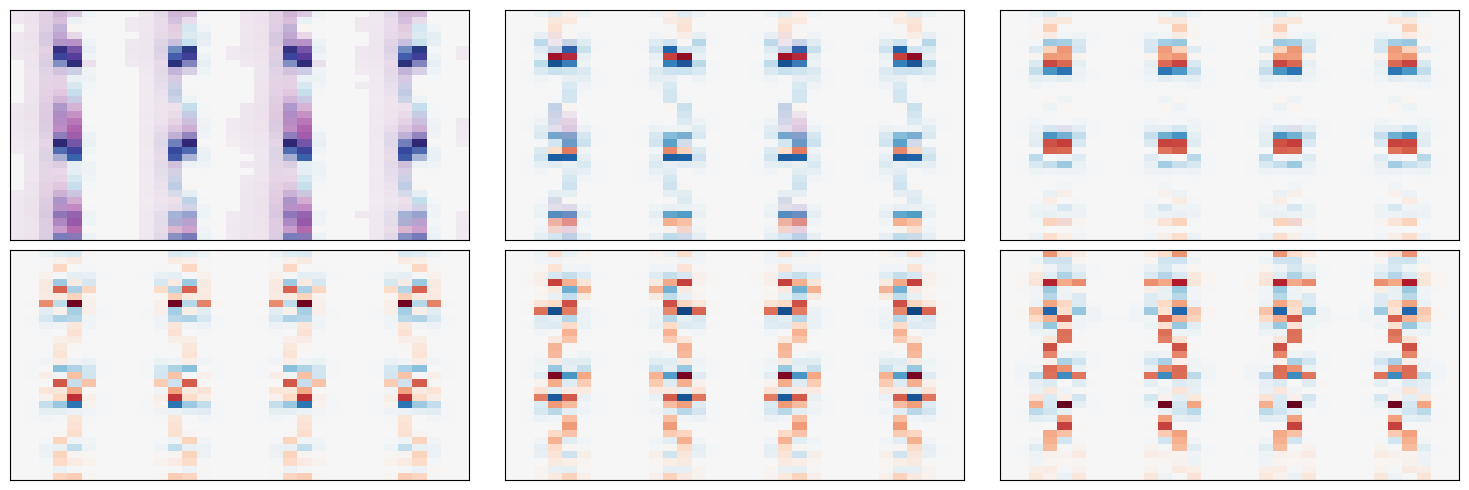

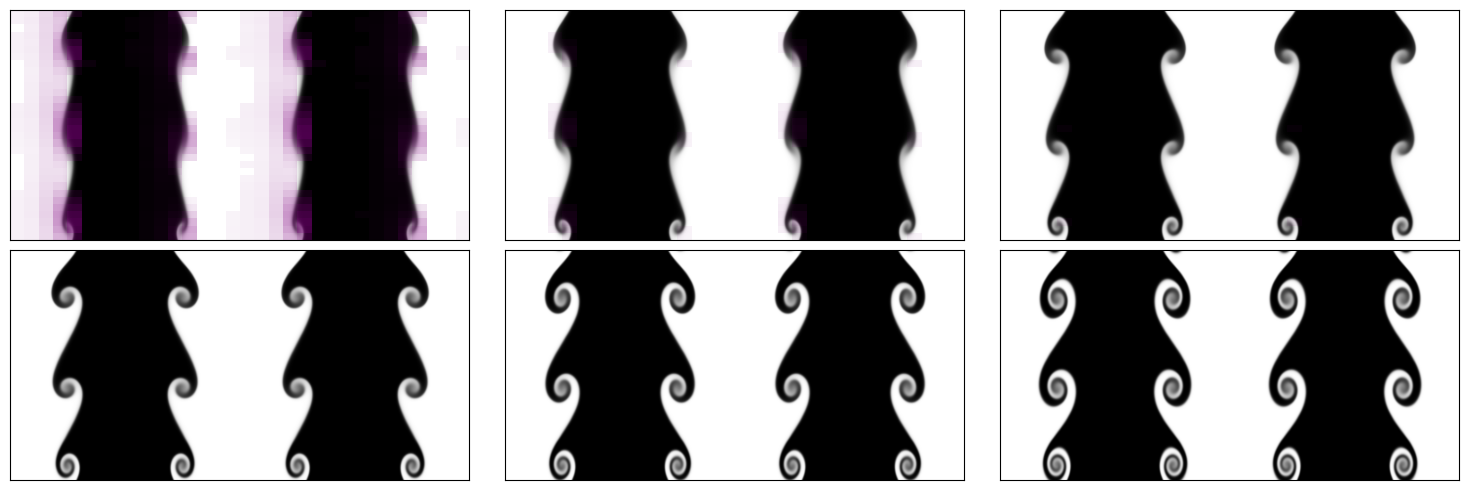

__________________________________
Feature 1035 has a correlation of 0.17 and a p-value of 7.45e-39


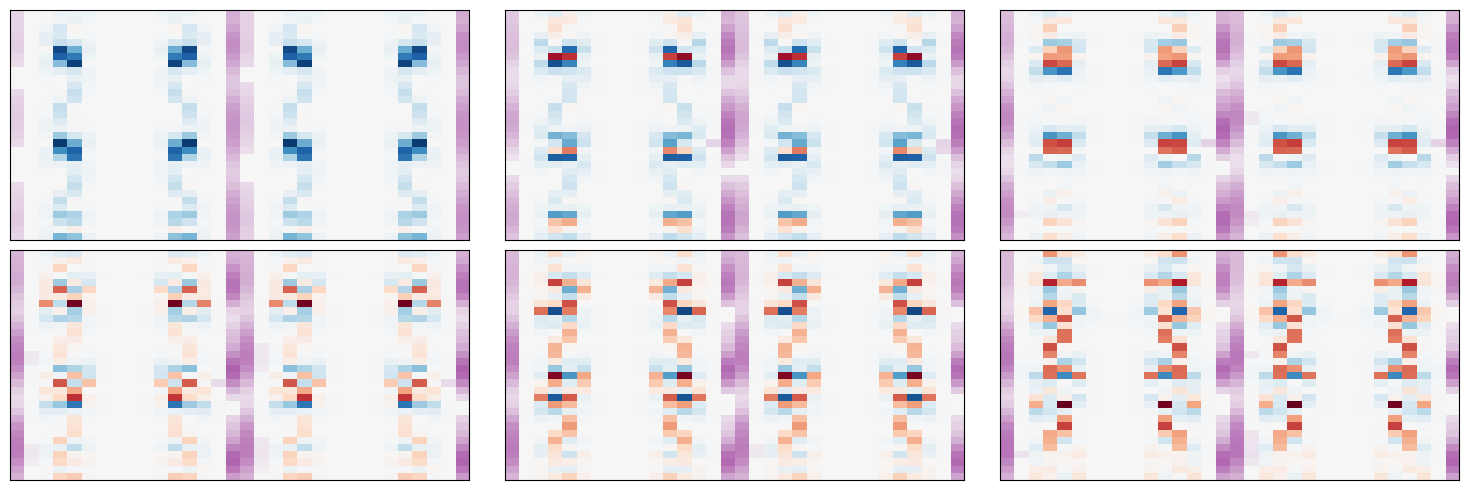

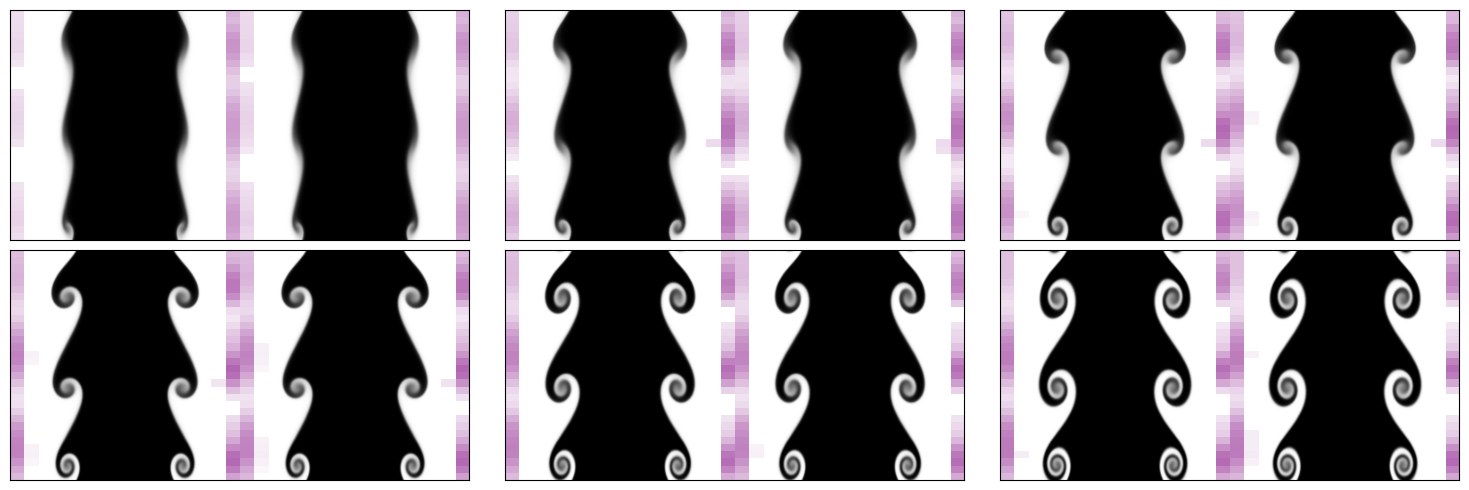

__________________________________
Feature 5899 has a correlation of 0.17 and a p-value of 9.33e-39


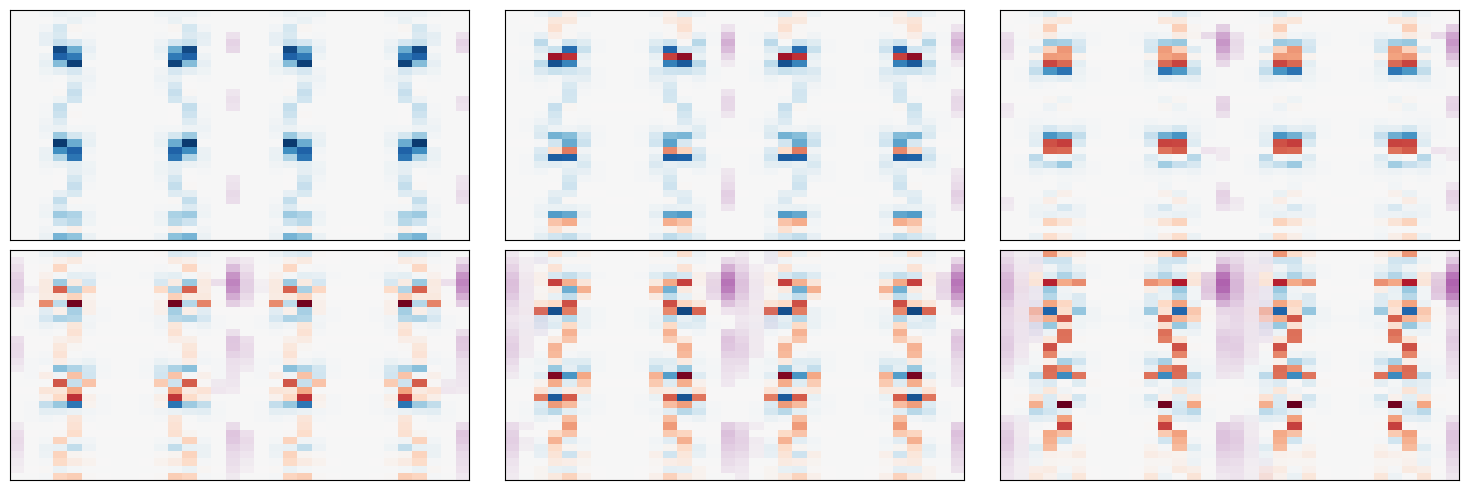

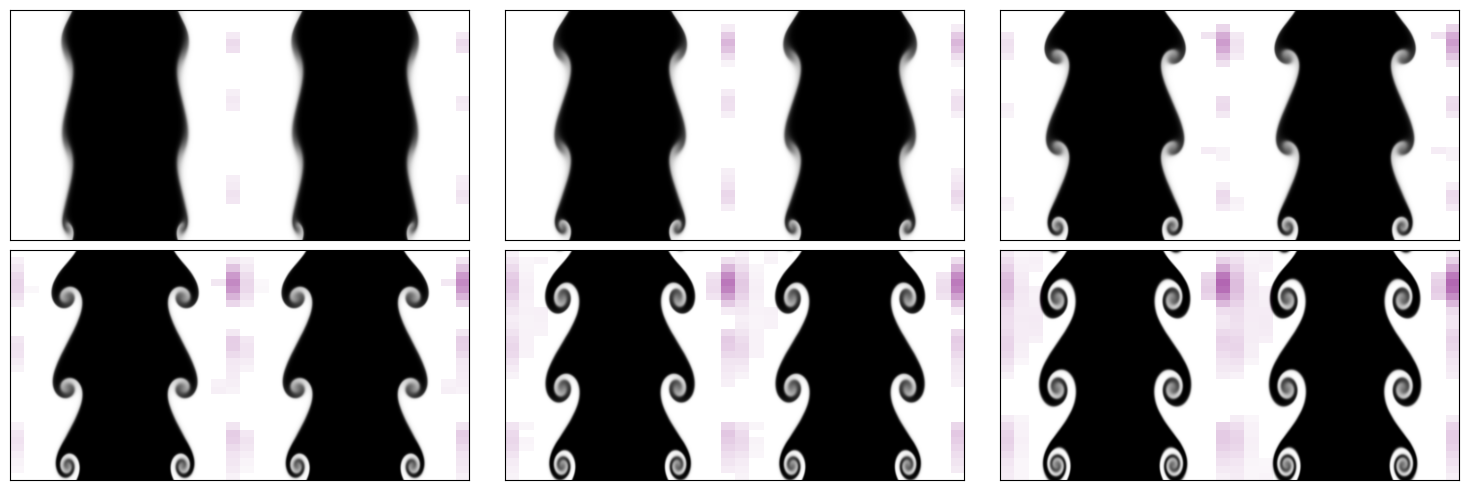

__________________________________


In [28]:
# Sort by significance
for cnt,i in enumerate(significant_features_indices):
    if cnt == 4:
        break
    feature = feature_list[i]
    print(f"Feature {feature.index} has a correlation of {correlations[cnt]:.2f} and a p-value of {p_values[cnt]:.2e}")
    plot_feature(feature_list[i], enstrophy_data, show_simulation=False)
    plot_feature(feature_list[i], enstrophy_data, show_simulation=True)
    print('__________________________________')


In [ ]:
# Combine the features in order of correlation 

In [ ]:
for cnt,i in enumerate(significant_features_indices[::-1]):
    if cnt > 1:
        break
    feature = feature_list[i]
    print(f"Feature {feature.index} has a correlation of {correlations[cnt]:.2f} and a p-value of {p_values[cnt]:.2e}")
    plot_feature(feature_list[i], enstrophy_data, show_simulation=False)
    plot_feature(feature_list[i], enstrophy_data, show_simulation=True)
    print('__________________________________')

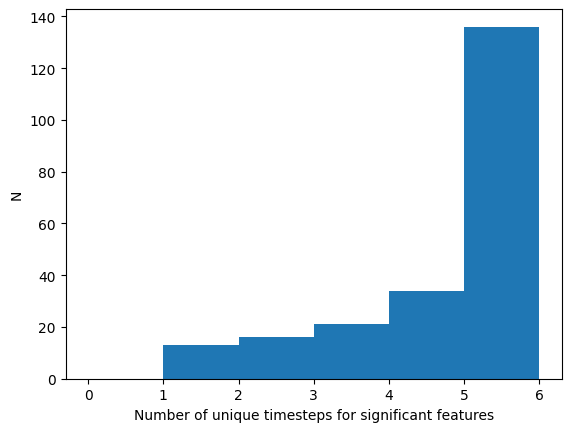

In [41]:
# For the significant features, count the number of timesteps when the feature is > 0
significant_features = [feature_list[i] for i in significant_features_indices]
n_unique_timesteps = []
for feature in significant_features:
    activations = code[:, feature.index]
    mask = np.argwhere(activations > 0)
    indices = np.unravel_index(mask, (6, 32, 32))
    bins = np.arange(0, 6+1)
    counts = np.histogram(indices[0].flatten(), bins = bins)[0]
    n_unique_timesteps.append(np.sum(counts > 0))

plt.figure()
plt.hist(n_unique_timesteps, bins = np.arange(0, 6+1))
plt.xlabel("Number of unique timesteps for significant features")
plt.ylabel("N")
plt.show()

selection 37: Feature(index=9166, dEdt=-0.01728734867567747, num_active=615)


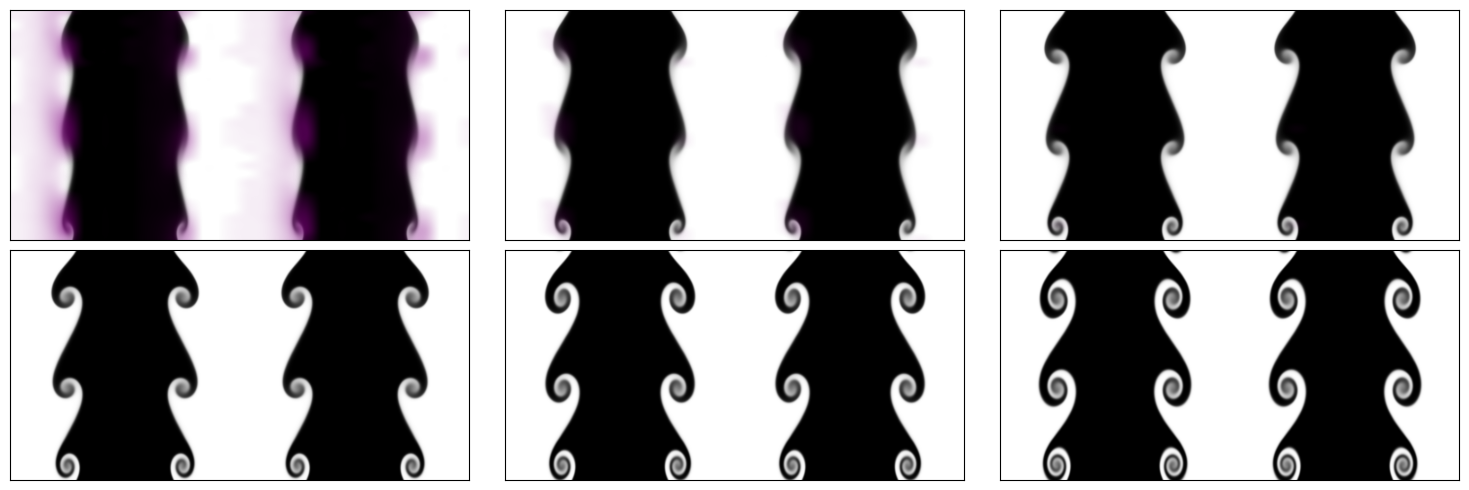

In [31]:
# Find token with smallest dEdT where the fraction of active tokens is greater than 5%
# NOTE: This does not seem to work so well
thresh = 5
for i, feature in enumerate(feature_list):
    if 100 * feature.num_active / (32 * 32 * 6) > thresh:
        break
feature = feature_list[i]
print(f"selection {i}: {feature}")
plot_feature(feature, enstrophy_data)

### Conditional analysis

In [73]:
for cnt, feature in enumerate(significant_features):
    if cnt > 1:
        break

    active_mask = code[:, feature.index] > 0

    cascade_when_active = np.mean(enstrophy_data.dEdt.flatten()[active_mask])
    cascade_when_inactive = np.mean(enstrophy_data.dEdt.flatten()[~active_mask])

    t_stat, p_value = stats.ttest_ind(enstrophy_data.dEdt.flatten()[active_mask], enstrophy_data.dEdt.flatten()[~active_mask])

    print(f"Feature {feature.index}:")
    print(f"  Mean cascade when active: {cascade_when_active:.3f}")
    print(f"  Mean cascade when inactive: {cascade_when_inactive:.3f}")
    print(f"  Difference: {cascade_when_active - cascade_when_inactive:.3f}")
    print(f"  t-statistic: {t_stat:.2f}, p-value: {p_value:.2e}")

for cnt, feature in enumerate(significant_features[::-1]):
    if cnt > 1:
        break

    active_mask = code[:, feature.index] > 0

    cascade_when_active = np.mean(enstrophy_data.dEdt.flatten()[active_mask])
    cascade_when_inactive = np.mean(enstrophy_data.dEdt.flatten()[~active_mask])

    t_stat, p_value = stats.ttest_ind(enstrophy_data.dEdt.flatten()[active_mask], enstrophy_data.dEdt.flatten()[~active_mask])

    print(f"Feature {feature.index}:")
    print(f"  Mean cascade when active: {cascade_when_active:.3f}")
    print(f"  Mean cascade when inactive: {cascade_when_inactive:.3f}")
    print(f"  Difference: {cascade_when_active - cascade_when_inactive:.3f}")
    print(f"  t-statistic: {t_stat:.2f}, p-value: {p_value:.2e}")

Feature 9301:
  Mean cascade when active: -0.010
  Mean cascade when inactive: -0.001
  Difference: -0.010
  t-statistic: -18.44, p-value: 6.19e-74
Feature 9166:
  Mean cascade when active: -0.010
  Mean cascade when inactive: -0.000
  Difference: -0.010
  t-statistic: -20.56, p-value: 6.45e-91
Feature 1035:
  Mean cascade when active: -0.000
  Mean cascade when inactive: -0.002
  Difference: 0.002
  t-statistic: 3.54, p-value: 4.08e-04
Feature 5899:
  Mean cascade when active: 0.000
  Mean cascade when inactive: -0.002
  Difference: 0.002
  t-statistic: 3.12, p-value: 1.80e-03
